# Imports

In [5]:
#!pip install tensorflow ipympl matplotlib tf2onnx seaborn joblib
import os
import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid
from scipy.stats import qmc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib #to save Scalers
from sklearn.metrics import mean_squared_error
import seaborn as sns
import keras
from keras.models import Sequential, Model
from keras import Input
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, Callback
from keras import Loss
from keras.saving import custom_object_scope
import tf2onnx
from src._utils.utils import load_yaml_file

PHYSICS_PARAMS = load_yaml_file("src/config.yml")["PHYSICS_PARAMS"]

## Helper funcs

In [31]:
def comparison_plot(t: np.ndarray, true_data: np.ndarray,
                     pred_data: list[tuple[np.ndarray, str]], suptitle: str,
                     meas_data: np.ndarray = None):
    '''
    true_data: contains acc, vel (in m/s), and pos in (t, 3) shape
    '''
    # Plot for acceleration:
    plt.figure()
    plt.plot(t, true_data[:, 0], label="True Acceleration", linewidth=2)
    for data, label in pred_data:
        plt.plot(t, data[:, 0], '--', label=label, linewidth=2)
    if meas_data is not None:
        plt.scatter(t, meas_data, label="Measured acceleration points", s=7, c='red')
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s^2)")
    plt.title("Acceleration")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot for velocity:
    plt.figure()
    plt.plot(t, true_data[:, 1]*3.6, label="True Velocity", linewidth=2) #conversion from m/s to km/h
    for data, label in pred_data:
        plt.plot(t, data[:, 1]*3.6, '--', label=label, linewidth=2)
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (km/h)")
    plt.title("Velocity")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot for position
    plt.figure()
    plt.plot(t, true_data[:, 2], label="True Position", linewidth=2)
    for data, label in pred_data:
        plt.plot(t, data[:, 2], '--', label=label, linewidth=2)
    plt.xlabel("Time (s)")
    plt.ylabel("Displacement (m)")
    plt.title("Position")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

def loss_plot(history, es_start_epoch):
    loss = history["loss"]
    val_loss = history["val_loss"]
    best_epoch = es_start_epoch + np.argmin(val_loss[es_start_epoch:]) + 1

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(loss) + 1), loss, label="Training Loss")
    plt.plot(range(1, len(loss) + 1), val_loss, label="Validation Loss (against ground truth)")
    plt.yscale("log")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid()
    plt.title("Evolution of training and validation losses")

    #add a marker for the early stopping epoch
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Restored')
    plt.text(best_epoch, val_loss[best_epoch - 1], f'({best_epoch}, {val_loss[best_epoch - 1]:.5e})',
             color='b', fontsize=12)

    plt.legend()
    plt.show()

def evaluate_results(model, X_norm, true_data, dt, scaler_Y=None):
    v = np.zeros_like(X_norm[:, 0]) #first feature is t
    x = np.zeros_like(X_norm[:, 0])

    pred_a = model.predict(X_norm, verbose=0)

    if scaler_Y:
        pred_a = scaler_Y.inverse_transform(pred_a)
    v = cumulative_trapezoid(pred_a.flatten(), dx=dt, initial=0)
    v += true_data[0,1]
    x = cumulative_trapezoid(v, dx=dt, initial=0)
    x += true_data[0,2]

    mse_a = mean_squared_error(true_data[:, 0], pred_a)
    mse_v = mean_squared_error(true_data[:, 1], v)
    mse_x = mean_squared_error(true_data[:, 2], x)

    v = v.reshape(-1, 1)
    x = x.reshape(-1, 1)

    pred_data = np.hstack((pred_a, v, x))

    print(f"MSE/RMSE for acceleration: {mse_a:.5e}, {np.sqrt(mse_a):.5e}")
    print(f"MSE/RMSE for velocity: {mse_v:.5e}, {np.sqrt(mse_v):.5e}")
    print(f"MSE/RMSE for position: {mse_x:.5e}, {np.sqrt(mse_x):.5e}")

    return pred_data

# Prepping data

## DEFINE HERE THE TRAINING SETUP

In [10]:
traj_id = ["udds", "hwycol", "nycccol"] #* CHANGE HERE TRAINING DATA
dataframes = []
for traj in traj_id:
    dataframes.append(pd.read_csv("data/driving_cycles/CACC_" + traj + ".csv"))
    df = pd.concat(dataframes)
train_ratio = .7
dataframes_str = "_".join(traj_id)
model_name = f"ANN_{dataframes_str}_{int(train_ratio*100)}%" #name to use for saves
print(model_name)
df.head()

ANN_udds_hwycol_nycccol_70%


,t,fv0_x,fv0_v_noise,fv0_v,fv0_u,fv0_a_noise,fv0_a,lv_x,lv_v_noise,lv_v,d_fv0_lv_noise,d_fv0_lv,d*_fv0_lv
0,0.0,-20.00000,-0.029503,0.0000,4.477721,4.190644,4.208,0.000000e+00,0.010140,0.000000e+00,20.089231,20.00000,2.0000
1,0.1,-19.97896,0.412804,0.4208,4.478601,4.203216,4.208,1.010206e-17,0.035353,2.020411e-16,20.012920,19.97896,2.4208
2,0.2,-19.91584,0.828050,0.8416,4.479590,4.223206,4.208,3.816332e-17,0.006467,3.591842e-16,19.944470,19.91584,2.8416
3,0.3,-19.81064,1.264956,1.2624,4.480690,4.203192,4.208,7.969400e-17,0.011232,4.714293e-16,19.807995,19.81064,3.2624
4,0.4,-19.66336,1.681171,1.6832,4.481898,4.213076,4.208,1.302043e-16,0.003388,5.387764e-16,19.672709,19.66336,3.6832


dt=0.1
Number of training points:
(19124, 1)
Number of validation points:
(8196, 1)


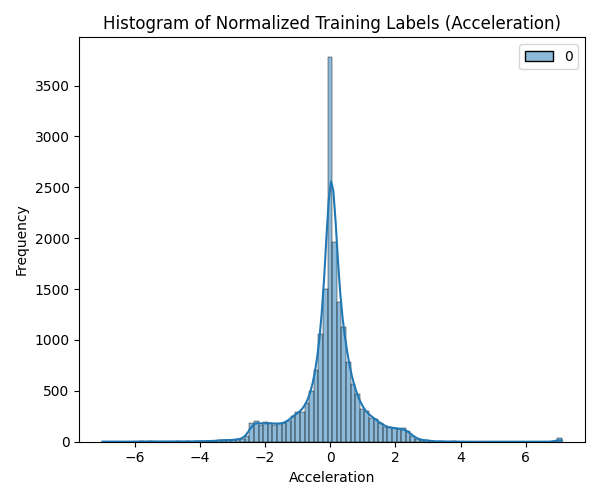

In [17]:
X = df[["t", "fv0_u", "fv0_v_noise", "d_fv0_lv_noise", "d*_fv0_lv", "lv_v_noise"]].to_numpy()
n_features = X.shape[1]
t = X[:, 0]
dt = t[1] - t[0]
print(f"dt={dt}")
Y = df[["fv0_a_noise"]].to_numpy()  #NN predicts instantaneous acceleration
y0 = Y[0]

Y_train, Y_val, X_train, X_val = train_test_split(Y, X, train_size=train_ratio, random_state=31)
print("Number of training points:")
print(Y_train.shape)
print("Number of validation points:")
print(Y_val.shape)

""" #Visualize training data provided to model:
mask = np.isin(Y, Y_train)
Y_mask = Y.copy()
Y_mask[~mask] = np.nan
plt.scatter(t, Y_mask, label="Selected accel for training (m/s^2)", s=5, color="red")
plt.plot(t, Y, label="True acceleration", linewidth=2, color="green")
plt.legend()
plt.show() """

#Prediction Normalization
scaler_Y = StandardScaler().fit(Y_train)
joblib.dump(scaler_Y, f"models/scalers/scalerY_{model_name}.save")
Y_train_norm = scaler_Y.transform(Y_train)
Y_val_norm = scaler_Y.transform(Y_val)

# feature normalization
scaler_X = MinMaxScaler().fit(X_train)
joblib.dump(scaler_X, f"models/scalers/scalerX_{model_name}.save")
X_train_norm = scaler_X.transform(X_train)
X_val_norm = scaler_X.transform(X_val)
X_norm = scaler_X.transform(X)
x0_norm = X_norm[0, :]

# Plot histogram for output
plt.figure(figsize=(6, 5))
sns.histplot(Y_train_norm, bins=100, kde=True, color='orange')
plt.title('Histogram of Normalized Training Labels (Acceleration)')
plt.xlabel('Acceleration')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# PUNN-only

Epoch 1/2000
598/598 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.8459 - val_loss: 0.4766 - learning_rate: 1.0000e-04
Epoch 2/2000
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2846 - val_loss: 0.0240 - learning_rate: 1.0000e-04
Epoch 3/2000
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0193 - val_loss: 0.0111 - learning_rate: 1.0000e-04
Epoch 4/2000
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0085 - val_loss: 0.0048 - learning_rate: 1.0000e-04
Epoch 5/2000
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0042 - val_loss: 0.0026 - learning_rate: 1.0000e-04
Epoch 6/2000
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0018 - val_loss: 0.0011 - learning_rate: 1.0000e-04
Epoch 7/2000
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0013 - val_loss: 0.0012 - learning_rate: 1.0000e-04
Epoch 8/2000
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0010 - val_loss: 9.5903e-04 - learning_rate: 1.0000e-04
Epoch 9/2000
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0011

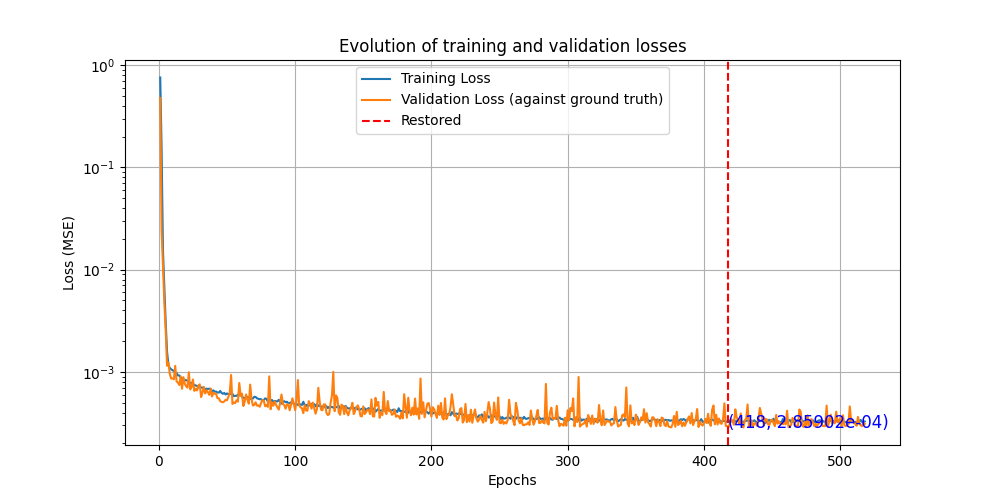

257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - loss: 2.8786e-04


0.00028590200236067176

In [34]:
#globals
#------
n_hid_layers = 3
n_neurons = 64
act = "tanh"
epochs = 2000
patience = 100
start_from_epoch = 200
loss = "mse"
metrics = []
schedule_tg = 100
opt = Adam(learning_rate=1e-4, weight_decay=1e-2)
batch = 32
#------

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience,
                               restore_best_weights=True, start_from_epoch=start_from_epoch)
def lr_schedule(epoch, lr):
    if (epoch+1) % schedule_tg == 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

checkpoint = ModelCheckpoint(
    filepath=f'models/punn_{model_name}.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

#PUNN
punn_model = Sequential()
punn_model.add(Input(shape=(n_features, ))) #_ for batch dim
for _ in range(0,n_hid_layers):
    punn_model.add(Dense(n_neurons, activation=act))
punn_model.add(Dense(1, activation="linear")) #output layer -> a^

punn_model.compile(optimizer=opt, metrics=metrics, loss=loss)
#punn_model.summary()
#first column of Y is the label: acceleration
history_punn_fwd = punn_model.fit(x=X_train_norm, y=Y_train_norm, validation_data=(X_val_norm, Y_val_norm),
                                  batch_size=batch, epochs=epochs, callbacks=[early_stopping, lr_scheduler, checkpoint], verbose=True)
loss_plot(history_punn_fwd.history, start_from_epoch)
punn_model.evaluate(x=X_val_norm, y=Y_val_norm, batch_size=batch) #just to confirm final validation loss

## PUNN predictions
offline integration for testing, in reality it would be real-time

## Testing trajectory

Testing trajectory (us06col) statistics: 
MSE/RMSE for acceleration: 5.15747e-05, 7.18155e-03
MSE/RMSE for velocity: 5.25492e+03, 7.24908e+01
MSE/RMSE for position: 3.31717e+08, 1.82131e+04
----


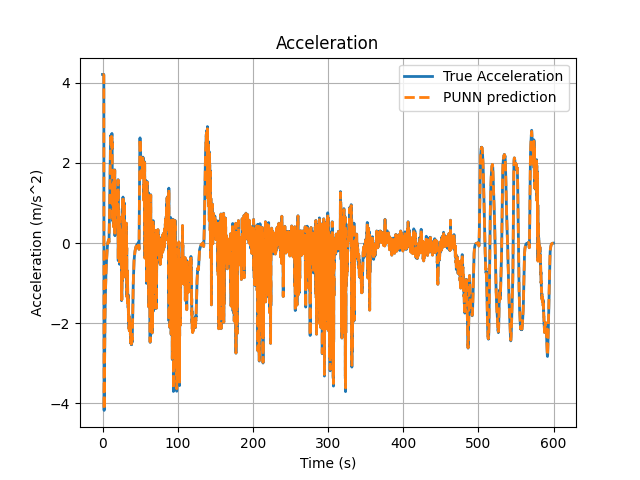

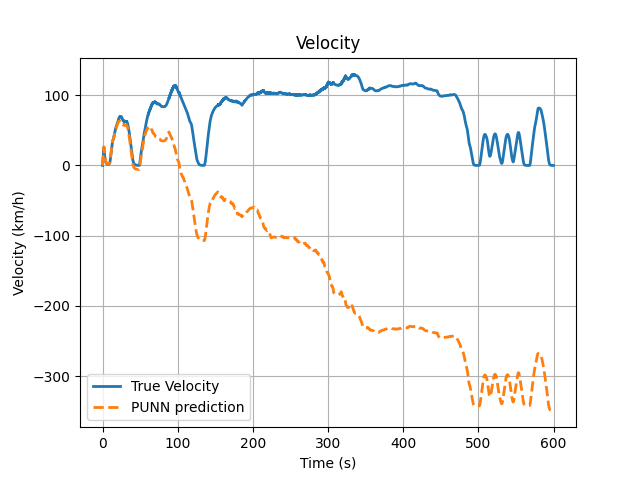

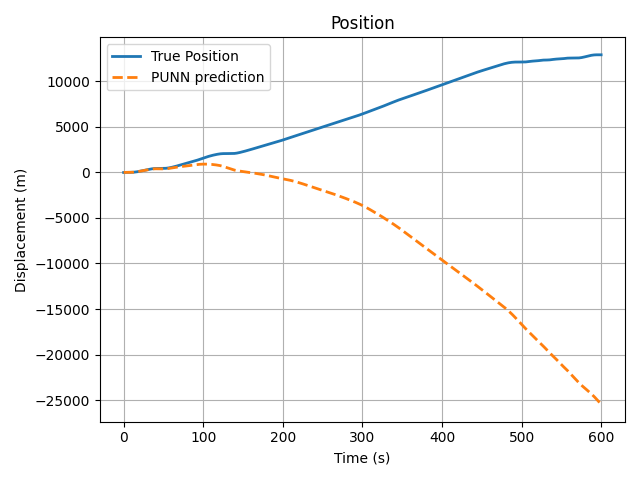

In [35]:
test_traj = "us06col"
punn_model = load_model(f"models/punn_{model_name}.keras", compile=False)  # Load model just for prediction
df_test = pd.read_csv("data/driving_cycles/CACC_" + test_traj + ".csv")
X_test = df_test[["t", "fv0_u", "fv0_v_noise", "d_fv0_lv_noise", "d*_fv0_lv", "lv_v_noise"]].to_numpy()
X_test_norm = scaler_X.transform(X_test)
true_data = df_test[["fv0_a", "fv0_v", "fv0_x"]].to_numpy()
print("Testing trajectory (" + str(test_traj) + ") statistics: ")
punn_test_traj_eval = evaluate_results(model=punn_model, X_norm=X_test_norm, true_data=true_data, scaler_Y=scaler_Y, dt=dt)
print("----")
comparison_plot(t=df_test[["t"]], true_data=true_data, meas_data=None,
    pred_data=[(punn_test_traj_eval, "PUNN prediction")],
    suptitle="Predicted solution vs Ground Truth: PUNN-only for trajectory" + str(test_traj)
)

# PINN

## Combined Loss

In [ ]:
# collocation points
collocation_size = 10000
print("Number of collocation points: " + str(collocation_size))
#dimension size -> ["t", "fv0_u", "fv0_v_noise", "d_fv0_lv_noise", "d*_fv0_lv", "lv_v_noise"]
sampler = qmc.LatinHypercube(d=n_features)
collocation = sampler.random(n=collocation_size)
print(qmc.discrepancy(collocation)) #evaluate sampling distribution
u_min = PHYSICS_PARAMS["a_min"]*PHYSICS_PARAMS["m"]
u_max = PHYSICS_PARAMS["a_max"]*PHYSICS_PARAMS["m"]
v_max = PHYSICS_PARAMS["v_max"]
t_min = 0
t_max = 120
l_bounds = [t_min, u_min, 0.0, 1, 1, 0.0]
u_bounds = [df['t'].max(), u_max, v_max, max(df['d_fv0_lv'].max(), 100),
            max(df['d*_fv0_lv'].max(), 100), v_max]
print(l_bounds)
print(u_bounds)
X_c = qmc.scale(collocation, l_bounds=l_bounds, u_bounds=u_bounds).astype(np.float32)
pd.DataFrame(X_c).to_csv("data/collocation_data.csv")

Number of collocation points: 10000
7.03802414612209e-05
[0, -10272.0, 0.0, 1, 1, 0.0]
[1368.95, 5404.040404040405, 38.888888888888886, 100, 100, 38.888888888888886]


In [8]:
@keras.saving.register_keras_serializable()
class PinnModel(keras.Model):
    def __init__(self, true_phy_params, train_params,
                 n_hid_layers, n_neurons, act="tanh", **kwargs):
        super().__init__(**kwargs)
        self.true_params  = true_phy_params
        self.params = self.true_params
        self.train_params = train_params
        self.n_hid_layers = n_hid_layers
        self.n_neurons = n_neurons
        self.act = act

        #Architecture
        self.hidden_layers = [
            Dense(n_neurons, activation=act,
                                  name=f"dense_{i}")
            for i in range(n_hid_layers)
        ]
        self.out_layer = Dense(1, activation="linear")

        #physics setup
        for key, value in self.params.items():
            if key in self.train_params.keys(): #if joint training
              init = keras.initializers.Constant(self.train_params[key])
              self.params[key] = self.add_weight(name=key, shape=(), initializer=init,
                                                   trainable=True, dtype=tf.float32)
            else: #for given true values
              self.params[key] = tf.constant(value, dtype=tf.float32, name=key)

    def call(self, inputs, training=False):
        x = inputs
        for lyr in self.hidden_layers:
            x = lyr(x)
        return self.out_layer(x)

    def get_config(self):
        return { #add to super config
            "true_phy_params": self.true_params,
            "train_params"   : self.train_params,
            "n_hid_layers"   : self.n_hid_layers,
            "n_neurons"      : self.n_neurons,
            "act"            : self.act,
            **super().get_config()
        }

class CombinedLoss(Loss):
    def __init__(self, model: keras.Model, X_c: np.ndarray,
                 scaler_X: MinMaxScaler, scaler_Y: StandardScaler, alpha: float):
        '''
        Assumes u feature in second column of X_c provided and v in third.
        '''
        super().__init__()

        self.model = model
        self.alpha_d = alpha  #dictates data/physics ratio
        self.alpha_p = 1-alpha
        self.scaler_X = scaler_X
        self.scaler_Y = scaler_Y

        self.u_phy = tf.constant(X_c[:, 1])
        self.v_phy = tf.constant(X_c[:, 2])

        self.X_c_norm = tf.constant(scaler_X.transform(X_c), dtype=tf.float32)

    def data_loss(self, y_true, y_pred):
        sqr_diff = tf.square(y_true - y_pred)
        return tf.reduce_mean(sqr_diff)

    def physics_loss(self):
        g = self.model.params['g']
        c0 = self.model.params['c0']
        c1 = self.model.params['c1']
        Cd = self.model.params['Cd']
        m = self.model.params['m']
        p = self.model.params['p']
        Af = self.model.params['Af']
        road_grade = self.model.params["road_grade"]

        a_norm = self.model(self.X_c_norm) #use PUNN to predict on collocation points
        a_norm = tf.reshape(a_norm, shape=([-1])) #flatten for shape matching
        a_phy = a_norm * self.scaler_Y.scale_ + self.scaler_Y.mean_ #denormalize

        #resistive forces
        Fr = (c0 + c1 * self.v_phy) * (m*g*tf.math.cos(road_grade))
        Fa = (p * Cd * Af * self.v_phy**2) / 2.0
        Fg = m *g*tf.math.sin(road_grade)

        #physics residuals
        flow = (self.u_phy - Fr - Fa - Fg)/m
        res = a_phy - flow  # Newton's law

        return tf.reduce_mean(tf.square(res))

    def call(self, y_true, y_pred):
        data_loss = self.data_loss(y_true, y_pred)
        pde_loss = self.physics_loss()

        return(
            self.alpha_d * data_loss +
            self.alpha_p * pde_loss
        )

## Training

Epoch 1/2000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'pinn_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


599/599 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 1.7269 - mse: 0.4193 - val_loss: 0.0271 - val_mse: 0.0085 - learning_rate: 0.0010
Epoch 2/2000
599/599 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0185 - mse: 0.0057 - val_loss: 0.0055 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 3/2000
599/599 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0044 - mse: 0.0014 - val_loss: 0.0021 - val_mse: 3.8279e-04 - learning_rate: 0.0010
Epoch 4/2000
599/599 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0027 - mse: 0.0014 - val_loss: 0.0051 - val_mse: 0.0054 - learning_rate: 0.0010
Epoch 5/2000
599/599 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0019 - mse: 0.0010 - val_loss: 0.0010 - val_mse: 3.5085e-04 - learning_rate: 0.0010
Epoch 6/2000
599/599 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0015 - mse: 0.0010 - val_loss: 0.0010 - val_mse: 6.9836e-04 - learning_rate: 0.0010
Epoch 7/2000
599/599 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0013 - mse: 0.0010 - val_loss: 0.0024 - val_mse: 0.0024 - learning_rate: 

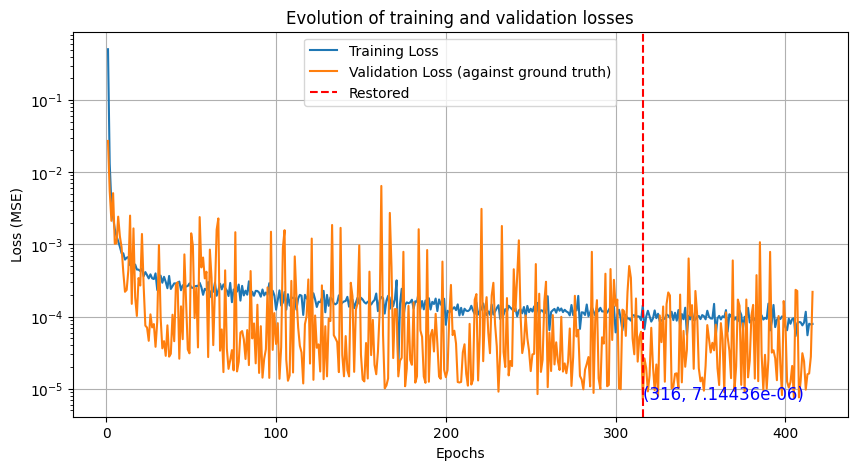

Model: "pinn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_0 (Dense)                 │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,501 (103.52 KB)

 Trainable params: 8,833 (34.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,668 (69.02 KB)

In [9]:
#globals
#------
n_features = X.shape[1]
n_hid_layers = 3
n_neurons = 64
act = "tanh"
epochs = 2000
patience = 100
start_from_epoch = 200
schedule_tg = 100
metrics = ["mse"]
opt = Adam(learning_rate=1e-3, weight_decay=1e-2)
batch = 32
alpha = 0.5 #physics weight = 1-alpha
#don't think boundary loss is needed when providing the states directly,
# as they serve as x0 -> a hard constraint for initial condition at each time step
true_phy_params = { #copied from above
    #*constant
    "g": PHYSICS_PARAMS["g"],
    "m": PHYSICS_PARAMS["m"], #kg toyota prius 2001 curb weight (fixed weight)
    # https://en.wikipedia.org/wiki/Automobile_drag_coefficient
    "Af": PHYSICS_PARAMS["Af"], # car cross sectional area
    "Cd": PHYSICS_PARAMS["Cd"], #toyota prius 2001
    #*variable
    #rolling resistance:
    "c0": PHYSICS_PARAMS["c0"],
    "c1": PHYSICS_PARAMS["c1"],
    "p": PHYSICS_PARAMS["p"], #average air density
    "road_grade": PHYSICS_PARAMS["road_grade"]
}
#train_params = {"m": 1000, "Af": 2.5, "Cd": 0.2} #if joint training provide initial values
train_params = {}
#------

pinn_model = PinnModel(true_phy_params, train_params, n_hid_layers, n_neurons, act)
#Custom PINN loss
loss = CombinedLoss(model=pinn_model, X_c=X_c, scaler_X=scaler_X, scaler_Y=scaler_Y, alpha=alpha)
pinn_model.build(input_shape=(None, n_features)) #none -> batch dim, defined later when fitting
pinn_model.compile(optimizer=opt, metrics=metrics, loss=loss)

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience,
                               restore_best_weights=True, start_from_epoch=start_from_epoch)

def lr_schedule(epoch, lr):
    if (epoch+1) % schedule_tg == 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

checkpoint = ModelCheckpoint(
    filepath=f'models/pinn_{model_name}.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

class CustomWeightLog(Callback):
    def __init__(self):
        super().__init__()

    def on_epoch_end(self, epoch, logs=None):
        if len(self.model.train_params) > 0: #if joint training
          for key, value in self.model.params.items():
              logs[key] = value
    def on_train_end(self, logs=None):
        print(f"Custom trainable weights converged to:")
        for key in self.model.train_params: #in trainable params list
            value = self.model.params[key]
            true_value = self.model.true_params[key]
            percentage = abs((value-true_value)/true_value)*100
            print(f"{key} = {value.numpy():.5e}, true value = {true_value} ({percentage:.3f}% difference)")

custom_weight_logger = CustomWeightLog()

callbacks = [early_stopping, lr_scheduler, checkpoint, custom_weight_logger]
#callbacks = [lr_scheduler, checkpoint, custom_weight_logger] #removed ES

#training
history_pinn_fwd = pinn_model.fit(x=X_train_norm, y=Y_train_norm,
                                  validation_data=(X_val_norm, Y_val_norm), #validating against true values here, not measurements
                                  batch_size=batch, epochs=epochs,
                                  callbacks=callbacks)
loss_plot(history_pinn_fwd.history, start_from_epoch)
pinn_model.summary()


# PUNN vs PINN

Converged phy values: {'g': <tf.Tensor: shape=(), dtype=float32, numpy=9.8100004196167>, 'm': <tf.Tensor: shape=(), dtype=float32, numpy=1284.0>, 'Af': <tf.Tensor: shape=(), dtype=float32, numpy=2.440000057220459>, 'Cd': <tf.Tensor: shape=(), dtype=float32, numpy=0.27000001072883606>, 'c0': <tf.Tensor: shape=(), dtype=float32, numpy=0.007499999832361937>, 'c1': <tf.Tensor: shape=(), dtype=float32, numpy=0.00019999999494757503>, 'p': <tf.Tensor: shape=(), dtype=float32, numpy=1.2039999961853027>, 'road_grade': <tf.Tensor: shape=(), dtype=float32, numpy=0.019997334107756615>}
Training trajectory (udds) statistics: 
PUNN:
MSE/RMSE for acceleration: 2.68442e-06, 1.63842e-03
MSE/RMSE for velocity: 1.18198e-01, 3.43800e-01
MSE/RMSE for position: 4.96751e+01, 7.04806e+00
PINN:
MSE/RMSE for acceleration: 3.38533e-06, 1.83993e-03
MSE/RMSE for velocity: 9.49240e-02, 3.08097e-01
MSE/RMSE for position: 3.83697e+01, 6.19432e+00
----


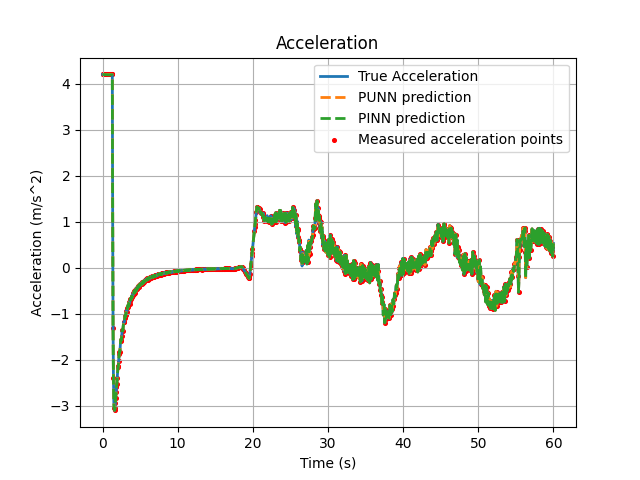

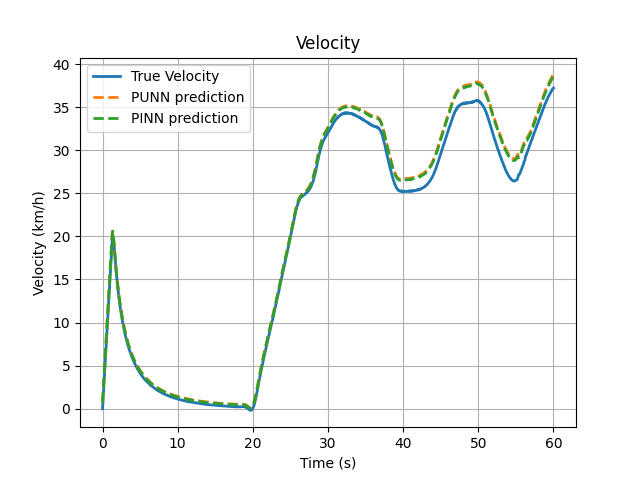

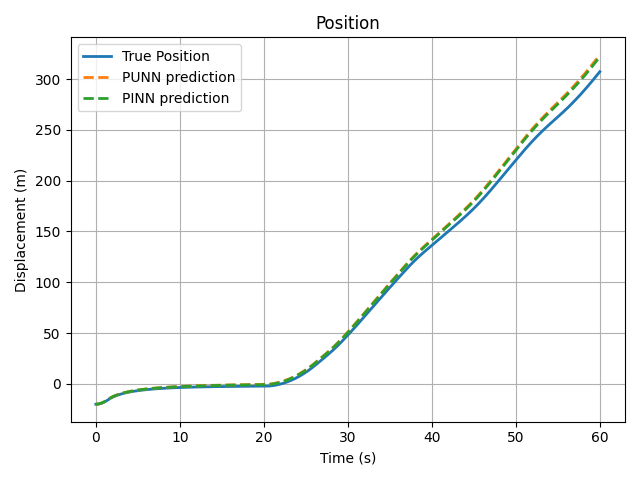

In [44]:
punn_model = load_model(f"models/punn_{model_name}.keras", compile=False)  # Load model just for prediction

#Load custom pinn model
custom_objects = {"PinnModel": PinnModel}#, "train_params": train_params, "true_phy_params": true_phy_params}
pinn_model = load_model(f"models/pinn_{model_name}.keras", custom_objects=custom_objects, compile=False)
print("Converged phy values:", pinn_model.params)
#Test - Confirm loss:
#pinn_model.compile(optimizer=opt, metrics=metrics, loss=loss)
#pinn_model.evaluate(x=X_val_norm, y=Y_val_norm, batch_size=batch)

# For training/validation trajectory:
t_start = 0
t_end = 60 #seconds
idx_start = int(t_start/dt)
idx_end = int(t_end/dt)+1
mask = (df["t"] >= t_start) & (df["t"] <= t_end) #trim data to specific segment: prevents integration error. More zoom also
eval_Y = df[mask][["fv0_a", "fv0_v", "fv0_x"]].to_numpy()
eval_X = df[mask][["t", "fv0_u", "fv0_v", "d_fv0_lv", "d*_fv0_lv", "lv_v"]].to_numpy()
eval_Y0 = eval_Y[0, 2], eval_Y[0, 1] #ini pos and vel
eval_X_norm = scaler_X.transform(eval_X)
t_eval = df[mask][["t"]].to_numpy()
meas_data = Y_mask[idx_start:idx_end, :]

print("Training trajectory (" + str(traj_id) + ") statistics: ")
print("PUNN:")
punn_train_traj_eval = evaluate_results(model=punn_model, X_norm=eval_X_norm, true_data=eval_Y, scaler_Y=scaler_Y, dt=dt, y0=eval_Y0)
print("PINN:")
pinn_train_traj_eval = evaluate_results(model=pinn_model, X_norm=eval_X_norm, true_data=eval_Y, scaler_Y=scaler_Y, dt=dt, y0=eval_Y0)
print("----")
comparison_plot(t=t_eval, true_data=eval_Y, meas_data=meas_data,
    pred_data=[(punn_train_traj_eval, "PUNN prediction"), (pinn_train_traj_eval, "PINN prediction")],
    suptitle="Predicted solution vs Ground Truth: PUNN vs PINN for trajectory " + str(traj_id)
)

Training trajectory (CACC_hwycol) statistics: 
PUNN:
MSE/RMSE for acceleration: 5.24643e-06, 2.29051e-03
MSE/RMSE for velocity: 2.87329e+01, 5.36030e+00
MSE/RMSE for position: 1.97298e+06, 1.40463e+03
PINN:
MSE/RMSE for acceleration: 1.55753e-06, 1.24801e-03
MSE/RMSE for velocity: 2.96205e+01, 5.44247e+00
MSE/RMSE for position: 2.09271e+06, 1.44662e+03
----


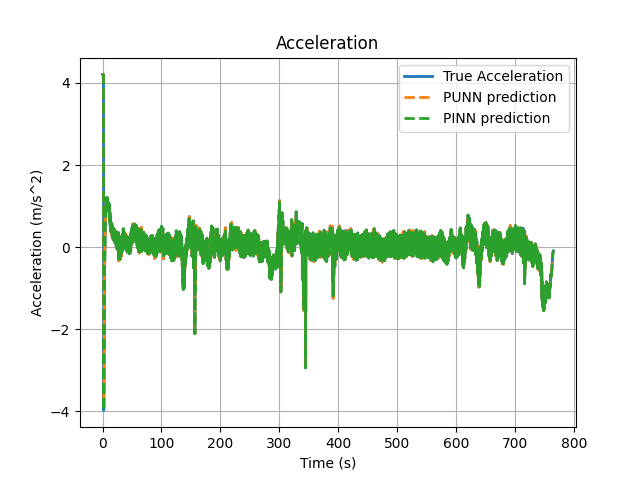

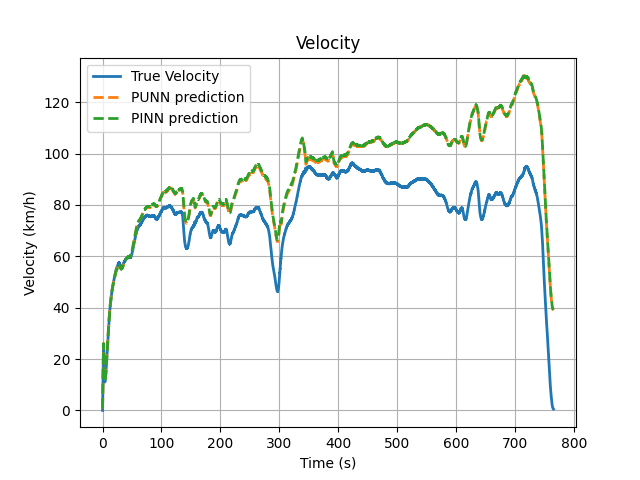

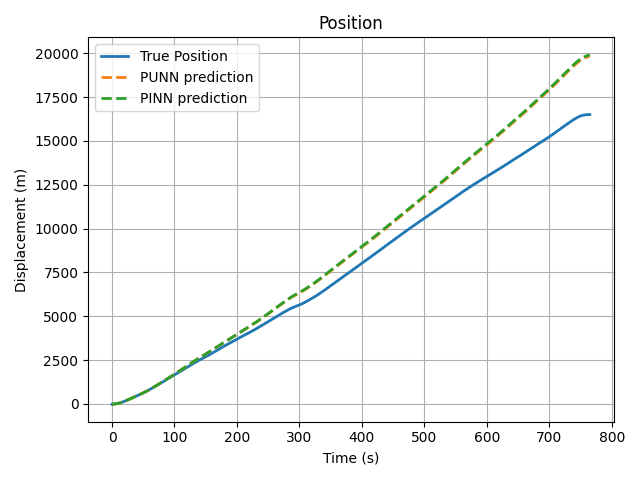

Training trajectory (CACC_nycccol) statistics: 
PUNN:
MSE/RMSE for acceleration: 1.11890e-05, 3.34500e-03
MSE/RMSE for velocity: 2.89365e-01, 5.37927e-01
MSE/RMSE for position: 3.08355e+04, 1.75600e+02
PINN:
MSE/RMSE for acceleration: 2.70712e-06, 1.64533e-03
MSE/RMSE for velocity: 5.72531e-02, 2.39276e-01
MSE/RMSE for position: 7.29026e+03, 8.53830e+01
----


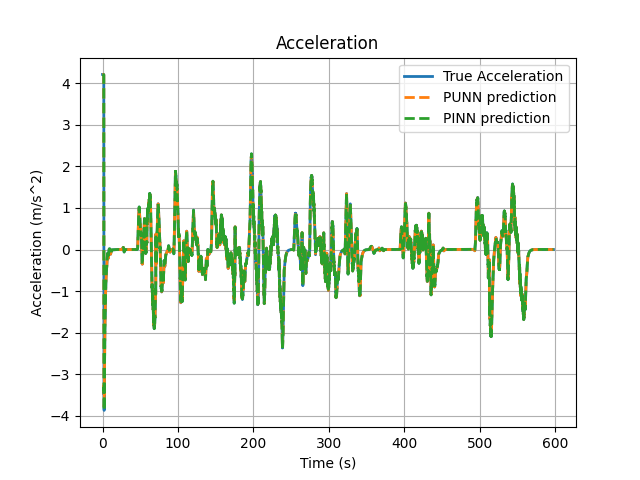

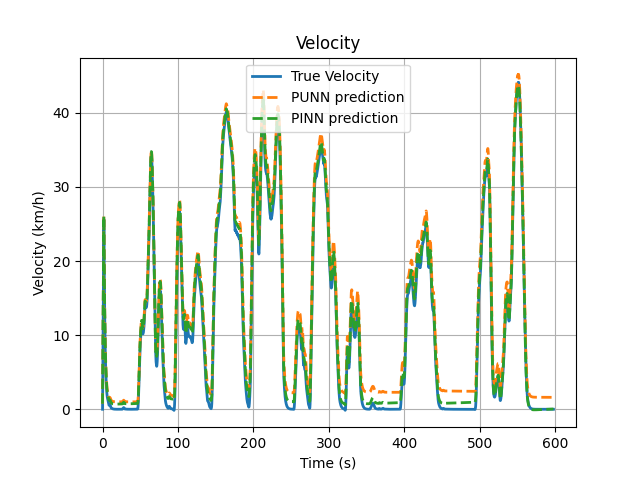

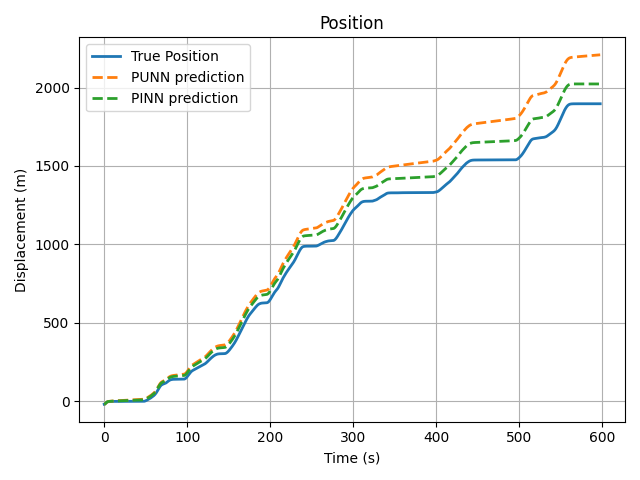

Training trajectory (CACC_us06col) statistics: 
PUNN:
MSE/RMSE for acceleration: 3.56357e-05, 5.96957e-03
MSE/RMSE for velocity: 1.39900e+03, 3.74032e+01
MSE/RMSE for position: 9.20646e+07, 9.59503e+03
PINN:
MSE/RMSE for acceleration: 5.00913e-06, 2.23811e-03
MSE/RMSE for velocity: 1.46836e+03, 3.83192e+01
MSE/RMSE for position: 9.54685e+07, 9.77080e+03
----


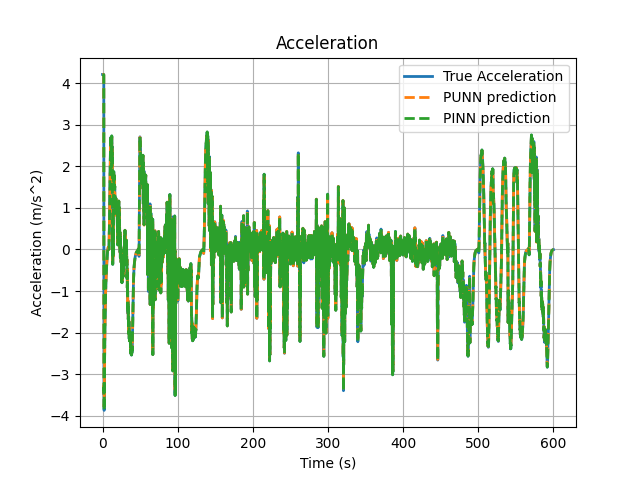

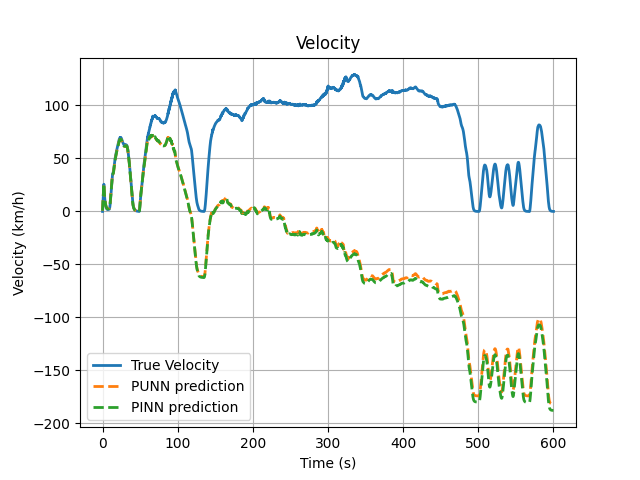

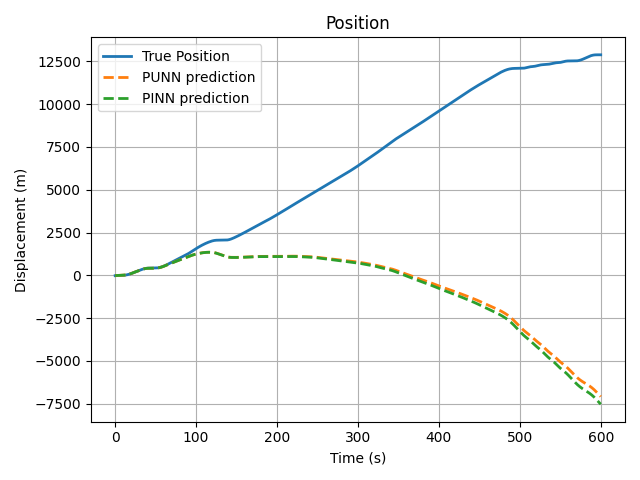

In [45]:
#TODO: change this
#*TESTING 
# Directory containing other driving cycles
driving_cycles_dir = "data/driving_cycles"
cycle_files = [f for f in os.listdir(driving_cycles_dir) if f.endswith(".csv")]
cycle_files = [f for f in cycle_files if traj_id not in f]

for cycle_file in cycle_files:
    test_id = os.path.splitext(cycle_file)[0]
    df_test = pd.read_csv(os.path.join(driving_cycles_dir, cycle_file))
    
    t_start = 0
    t_end = 1000 #seconds
    idx_start = int(t_start/dt)
    idx_end = int(t_end/dt)+1
    mask = (df_test["t"] >= t_start) & (df_test["t"] <= t_end)
    eval_Y = df_test[mask][["fv0_a", "fv0_v", "fv0_x"]].to_numpy()
    eval_X = df_test[mask][["t", "fv0_u", "fv0_v", "d_fv0_lv", "d*_fv0_lv", "lv_v"]].to_numpy()
    eval_Y0 = eval_Y[0, 2], eval_Y[0, 1] #ini pos and vel
    eval_X_norm = scaler_X.transform(eval_X)
    t_eval = df_test[mask][["t"]].to_numpy()

    print("Training trajectory (" + str(test_id) + ") statistics: ")
    print("PUNN:")
    punn_test_traj_eval = evaluate_results(model=punn_model, X_norm=eval_X_norm, true_data=eval_Y, scaler_Y=scaler_Y, dt=dt, y0=eval_Y0)
    print("PINN:")
    pinn_test_traj_eval = evaluate_results(model=pinn_model, X_norm=eval_X_norm, true_data=eval_Y, scaler_Y=scaler_Y, dt=dt, y0=eval_Y0)
    print("----")
    comparison_plot(t=t_eval, true_data=eval_Y, meas_data=None,
        pred_data=[(punn_test_traj_eval, "PUNN prediction"), (pinn_test_traj_eval, "PINN prediction")],
        suptitle="Predicted solution vs Ground Truth: PUNN vs PINN for trajectory " + str(test_id)
    )

# Convert to ONNX

In [13]:
custom_objects = {"PinnModel": PinnModel}
model = load_model(f"models/pinn_{model_name}.keras", custom_objects=custom_objects, compile=False)
input_shape = (1, n_features)
print("***Loading model...", f"Input shape = {input_shape}")

model_input_signature = [
    tf.TensorSpec(shape=input_shape, dtype=tf.float32, name='input'),
]
model.output_names = ['output'] #had to add this to prevent error. I think its because model hasnt been called yet
onnx_model, _ = tf2onnx.convert.from_keras(model,
    output_path=f'models/onnx/pinn{model_name}.onnx',
    input_signature=model_input_signature,
)

***Loading model... Input shape = (1, 6)
